# Intro

Welcome! This script will demonstrate how to do some basic things with the model. You will need credentials to access the database, as well as all required python packages installed.

# Setup

To get set up, we need to set a few environment variables. You'll have to modify the "GOOGLE_APPLICATION_CREDENTIALS" variable to point to your own credentials file.


In [13]:
# Note: you should fill in the appropriate values for the following environment variables. They aren't in the repo for security purposes
import os
os.environ['gcp_project'] = 'co-covid-models'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "co-covid-models-2910c8627310.json"

We also want this notebook's working directory to be the root of this repo. This command will change the working directory if necessary

In [14]:
if 'requirements.txt' not in os.listdir(os.getcwd()):
    os.chdir(os.path.join('..','..','..'))
os.getcwd()

'/Users/emwu9912/PycharmProjects/covid-models'

And finally let's set up logging so that we can print messages to the screen and also to a file simultaneously

In [15]:
import logging
from covid_model.utils import setup
outdir = setup('00000000_hello_world.ipynb')
logging.info("This is an example log message")

2022/06/30 15:10:13 INFO|============================================================
2022/06/30 15:10:13 INFO|This is an example log message


A copy of these logging messages (and more detailed messages not shown here by default) can be found in the `output\00000000_hello_world.ipynb` directory. Each time the `setup` function is run, a new logging file in that directory is created, with a name including the current timestamp.

In addition to your own logging messages, you will also see output from the model and various other functions, which are also logging their activity.

# Creating a model

To create a model, simply create an instance of the CovidModel class.

In [16]:
from covid_model import CovidModel
m1 = CovidModel()

2022/06/30 15:10:16 INFO|------------------------|{} Retrieving vaccinations data
2022/06/30 15:10:18 INFO|------------------------|{} Retrieving hospitalizations data


As you can see from the logging messages, the model automatically retrieved vaccination and hospitalization data from the database. __The data retrieved depend on the start and end dates of the model__, but since we didn't specify explicit start and end dates, default values are used.

## Setting the start and end dates of the model

Here are the default start and end dates of the model:

In [17]:
logging.info(f'Start Date: {m1.start_date}')
logging.info(f'End Date: {m1.end_date}')

2022/06/30 15:10:22 INFO|Start Date: 2020-01-01
2022/06/30 15:10:22 INFO|End Date: 2023-01-01


Internally, the model also numbers all the days between start and end date, where the start is always zero:

In [18]:
logging.info(f'Start time: {m1.tstart}')
logging.info(f'End time: {m1.tend}')

2022/06/30 15:10:24 INFO|Start time: 0
2022/06/30 15:10:24 INFO|End time: 1096


Updating the end date will also change `tend` for consistency

In [19]:
m1.end_date = '2022-10-01'
logging.info(f'End date: {m1.end_date}')
logging.info(f'End time: {m1.tend}')

2022/06/30 15:10:27 INFO|End date: 2022-10-01
2022/06/30 15:10:27 INFO|End time: 1004


Updating `tend` will also change the end date for consistency

In [20]:
m1.tend = 1045
logging.info(f'End time: {m1.tend}')
logging.info(f'End date: {m1.end_date}')

2022/06/30 15:10:29 INFO|End time: 1045
2022/06/30 15:10:29 INFO|End date: 2022-11-11


Updating the start date _will not_ change `tstart`, because `tstart` is always zero. But it _will_ change `tend`, because a new date is serving as the starting point. Note that the end _date_ has not been changed.

In [21]:
m1.start_date = '2020-01-24'
logging.info(f'End time: {m1.tend}')
logging.info(f'End date: {m1.end_date}')

2022/06/30 15:10:31 INFO|End time: 1022
2022/06/30 15:10:31 INFO|End date: 2022-11-11


Because `tstart` is always zero, it can't be changed manually:

In [22]:
m1.tstart = 1

AttributeError: can't set attribute

## Updating model data

If you change the start or end dates of the model, you'll probably have to reload the data to be consistent with the changes. Rather than automatically update data every time a change is made, data updating is done manually in order to minimize the number of queries to the database. This way a group of changes can be made and the update only needs to be performed once at the end.

In [23]:
m1.update_data()

2022/06/30 15:11:11 INFO|-----------------------|{} Retrieving vaccinations data
2022/06/30 15:11:13 INFO|-----------------------|{} Retrieving hospitalizations data


The update function only updates data that needs updating based on recent changes. If we run the function again, we see no logging output because no updates were necessary this time.

In [24]:
m1.update_data()

In addition to the start and end dates, there are other model properties which also affect the data going into the model

## Other User-Defined Model Properties

Technically any property of the model can be manually set by the user, but the `CovidModel` class is designed to manage most of its properties on its own, leaving only a handful of properties for the user to worry about. Here is a list of properties the user is commonly responsible for setting appropriately:

* `start_date`: we discussed this already
* `end_date`: ditto
* `params_defs`: this should either be set as a Python dictionary or a path to a json file (which will be converted to a Python dictionary behind the scenes). This specifies the vast majority of parameters used in the model, such as the infectiousness of a particular variant, the incubation period, the risk of hospitalization for a particular age group, the effect of vaccination, etc.
* `region_defs`: this should either be set as a Python dictionary of a path to a json file (same as above). This defines the possible regions that the model can use, along with the county names and FIPS codes associated with each region.
* `regions`: Python list of strings indicating which regions to model. The region_defs dictionary must contain an entry for each region listed.
* `vacc_proj_params`: Again, either a Python dictionary or path to a json file. This defines how vaccinations should be projected into the future to fill in gaps for vaccination data.
* `mobility_mode`: specifies how to incorporate mobility in the model. For a single region, this doesn't matter. When modeling multiple regions at the same time, this determines how disease transmits between regions from mobility.
* `mobility_proj_params`: Python dictionary or json file. Specifes how mobility shoul dbe projected into the future to fill in gaps for mobility data. Currently this is a placeholder, as mobility projections aren't implemented yet.
* `hosp_reporting_frac`: A dictionary which enables changes in hospital reporting over time. The assumption is hospitals are reporting some fraction of people which are actually hospitalized for or with COVID-19. If the fraction is 1, then we assume all cases are reported. Anything less than 1 indicates underreporting, presumably due to testing protocols and reporting requirements at the hospital.


Let's look at some default values. 

The default `params_defs` and `region_defs` are quite verbose, but each has a common format that you should familiarize yourself with. More detail on `params_defs` in particular can be found in the README.md file in this repository.

In [25]:
m1.params_defs

[{'param': 'region_pop',
  'attrs': {'region': 'co'},
  'vals': {'2020-01-01': 5805501},
  'desc': ''},
 {'param': 'region_pop',
  'attrs': {'region': 'ad'},
  'vals': {'2020-01-01': 520264},
  'desc': ''},
 {'param': 'region_pop',
  'attrs': {'region': 'ar'},
  'vals': {'2020-01-01': 656617},
  'desc': ''},
 {'param': 'region_pop',
  'attrs': {'region': 'bo'},
  'vals': {'2020-01-01': 328560},
  'desc': ''},
 {'param': 'region_pop',
  'attrs': {'region': 'brm'},
  'vals': {'2020-01-01': 72483},
  'desc': ''},
 {'param': 'region_pop',
  'attrs': {'region': 'den'},
  'vals': {'2020-01-01': 736522},
  'desc': ''},
 {'param': 'region_pop',
  'attrs': {'region': 'doug'},
  'vals': {'2020-01-01': 360939},
  'desc': ''},
 {'param': 'region_pop',
  'attrs': {'region': 'ep'},
  'vals': {'2020-01-01': 728077},
  'desc': ''},
 {'param': 'region_pop',
  'attrs': {'region': 'jeff'},
  'vals': {'2020-01-01': 599057},
  'desc': ''},
 {'param': 'region_pop',
  'attrs': {'region': 'lar'},
  'vals': {'

In [26]:
m1.region_defs

{'ad': {'name': 'Adams County',
  'counties': ['Adams'],
  'counties_fips': ['08001']},
 'ar': {'name': 'Arapahoe County',
  'counties': ['Arapahoe'],
  'counties_fips': ['08005']},
 'bo': {'name': 'Boulder County',
  'counties': ['Boulder'],
  'counties_fips': ['08013']},
 'brm': {'name': 'Broomfield County',
  'counties': ['Broomfield'],
  'counties_fips': ['08014']},
 'den': {'name': 'Denver County',
  'counties': ['Denver'],
  'counties_fips': ['08031']},
 'doug': {'name': 'Douglas County',
  'counties': ['Douglas'],
  'counties_fips': ['08035']},
 'ep': {'name': 'El Paso County',
  'counties': ['El Paso'],
  'counties_fips': ['08041']},
 'jeff': {'name': 'Jefferson County',
  'counties': ['Jefferson'],
  'counties_fips': ['08059']},
 'lar': {'name': 'Larimer County',
  'counties': ['Larimer'],
  'counties_fips': ['08069']},
 'mesa': {'name': 'Mesa County',
  'counties': ['Mesa'],
  'counties_fips': ['08077']},
 'pueb': {'name': 'Pueblo County',
  'counties': ['Pueblo'],
  'countie

By default, only one region is being modeled, the state of Colorado:

In [27]:
m1.regions

['co']

These next three properties are all "none" by default, and need to be specified by the user if any vaccination or mobility projections are desired, or if the model needs to enable disease transmission across regions.

In [29]:
m1.vacc_proj_params

In [30]:
m1.mobility_mode

In [31]:
m1.mobility_proj_params

Finally, the default hospital reporting fraction is set to 1 on January 24, 2020 and not changed for any later date. 

In [32]:
m1.hosp_reporting_frac

{'2020-01-24': 1}

This format of {date: value} is a common one that is also present in  `params_defs` as well as transmission control, `tc`. The idea is that values are set for a particular date, then assumed fixed until specified differently at a later date. So if we wanted to reflect a change in hospitalization reporting on May 2, 2020 reflecting a 20% drop in reported hospitalizations, we could do so like this:

`m1.hosp_reporting_frac = {'2020-01-24': 1, '2020-05-02': 0.8}`


## Creating a model with non-default properties

It is common to create a model and specify properties at the same time. Any model property can be passed as an argument to the CovidModel class. For instance, we could create a model with start and end dates, and specify the regions as well:

In [33]:
m2 = CovidModel(start_date = '2020-01-24', end_date='2022-10-15', regions=['met', 'ms'])

2022/06/30 15:16:40 INFO|------------------------|{} Retrieving vaccinations data
2022/06/30 15:16:45 INFO|------------------------|{} Retrieving hospitalizations data


It's also possible to specify all the non-default properties in a Python dictionary and pass that to the model with double asterisks (see [here](https://docs.python.org/3/tutorial/controlflow.html#unpacking-argument-lists)) like so:

In [38]:
model_args = {
    'params_defs': 'covid_model/analysis/00000000_hello_world/params.json',
    'region_defs': 'covid_model/input/region_definitions.json',
    'vacc_proj_params': 'covid_model/input/vacc_proj_params.json',
    'start_date': '2020-01-24',
    'end_date': '2021-11-09',
    'max_step_size': 1.0,       # The biggest allowable step (in days) that the ODE solver is allowed to take.
    'ode_method': 'RK23'        # what method to use when solving the ODE
}
m3 = CovidModel(**model_args)

2022/06/30 15:25:05 INFO|------------------------|{} Retrieving vaccinations data
2022/06/30 15:25:07 INFO|------------------------|{} Constructing vaccination projections
2022/06/30 15:25:07 INFO|------------------------|{} No vaccine projections necessary
2022/06/30 15:25:07 INFO|------------------------|{} Retrieving hospitalizations data


Notice there are a few properties that we haven't discussed yet, which relate to how the model solves the system of ODE's defining compartment dynamics.

## Defining a model using another model or from the database

Here are two other convenient ways of creating a model. First, you can specify a "base_model", which serves as the starting point for the new model:

In [39]:
m4 = CovidModel(base_model=m3, end_date = '2022-10-15')

2022/06/30 15:26:07 INFO|------------------------|{} Retrieving vaccinations data
2022/06/30 15:26:10 INFO|------------------------|{} Constructing vaccination projections
2022/06/30 15:26:11 INFO|------------------------|{} Retrieving hospitalizations data


`m4` is exactly the same as `m3`, except that it has a different `end_date`, and also, data like vaccinations and mobility will also be different to reflect this new `end_date`.

Finally, we can load a model from the database, using `base_spec_id`, which specifies which model specifications should be loaded from the database. Side note: we frequently write models to the database after fitting them, so the fitted models can be easily loaded and run or re-fit as necessary.

In [40]:
m5 = CovidModel(base_spec_id=2866, end_date = '2022-10-15')

2022/06/30 15:26:39 INFO|------------------------|{} Retrieving vaccinations data
2022/06/30 15:26:41 INFO|------------------------|{} Constructing vaccination projections
2022/06/30 15:26:41 INFO|------------------------|{} Retrieving hospitalizations data


# Prepping & Running the Model

Once you model, you solve the ODE's using the `solve_seir()` method. __However, before the model can be run, the parameters must be processed to produce the matrices that are necessary to solve the system of ODE's__. This critical step involves the model taking all of the parameter definitions, mobility & vaccination data, start & end dates, etc. and processing them into a series of vectors and matrices which capture the dynamics of the model at every point in time between `start_date` and `end_date`. The model will not be able to solve the ODE's without it.

Though the prep process is complicated behind the scenes, it's quite simple for you to do. Simply run the `prep()` method of the model you wish to build. Be patient, the this process can take a few (up to several) minutes to complete.

In [41]:
m3.prep(outdir=outdir)
logging.info("Finished Prepping!")

2022/06/30 15:32:54 INFO|----------------------|{} Prepping Model
2022/06/30 15:33:41 INFO|Finished Prepping!


After prepping the model, the only other necessary step is to set the _transmission control_, or TC, of the model, which controls the rate of transmission at any given time. This is done with the `update_tc()` method. Here we are specifying that at `t=0` (the first day), for the `'co'` regions, TC should be set to `0.75`. This value is implicitly fixed for all time since we don't specify any other values at any other `t`:

In [42]:
m3.update_tc({0: {'co': 0.75}})

After prepping the model, you can now solve the ODE's to your heart's content. The key function here is `solve_seir()`:

In [43]:
logging.info("Solving ODEs")
m3.solve_seir()
logging.info("solving done")

2022/06/30 15:34:53 INFO|Solving ODEs
2022/06/30 15:34:58 INFO|solving done


The result of running the above method is that we now have a numerical solution to the ODE's defining model dynamics. This means we now know how many people are in each compart between the start and end dates of the model. The solution is stored in `solution_y`, which is a Numpy array, where the rows are different days and the columns are different compartments. Here's a preview of that:

In [44]:
logging.info(f'Solution shape: {m3.solution_y.shape}')
m3.solution_y[:5, :5]

2022/06/30 15:35:08 INFO|Solution shape: (656, 2304)


array([[1.41116100e+06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.41116099e+06, 0.00000000e+00, 0.00000000e+00, 8.14520857e-07,
        1.06872346e-08],
       [1.41116094e+06, 0.00000000e+00, 0.00000000e+00, 2.29037954e-05,
        6.75207348e-07],
       [1.41116083e+06, 0.00000000e+00, 0.00000000e+00, 1.47997192e-04,
        6.89897396e-06],
       [1.41116065e+06, 0.00000000e+00, 0.00000000e+00, 5.28105868e-04,
        3.40461107e-05]])

A much more convenient way to inspect the solution is to look at `solution_ydf`, a Pandas dataframe holding the solution. Each column represents a different compartment, indicated by the column index, and each row is a different day, indicated by the row index. Here are the first 10 rows:

In [45]:
m3.solution_ydf.head(10)

seir                S                                                          \
age              0-19                                                           
vacc             none                                                           
variant          none                  wildtype                         alpha   
immun            none weak strong          none          weak    strong  none   
region             co   co     co            co            co        co    co   
t                                                                               
0        1.411161e+06  0.0    0.0  0.000000e+00  0.000000e+00  0.000000   0.0   
1        1.411161e+06  0.0    0.0  8.145209e-07  1.068723e-08  0.000026   0.0   
2        1.411161e+06  0.0    0.0  2.290380e-05  6.752073e-07  0.000740   0.0   
3        1.411161e+06  0.0    0.0  1.479972e-04  6.898974e-06  0.004778   0.0   
4        1.411161e+06  0.0    0.0  5.281059e-04  3.404611e-05  0.017041   0.0   
5        1.411160e+06  0.0    0.0  1.370171e-03  1.139811e-04  0.044188   0.0   
6        1.411160e+06  0.0    0.0  2.912864e-03  2.986959e-04  0.093884   0.0   
7        1.411160e+06  0.0    0.0  5.408564e-03  6.621179e-04  0.174215   0.0   
8        1.411159e+06  0.0    0.0  9.086573e-03  1.300136e-03  0.292499   0.0   
9        1.411159e+06  0.0    0.0  1.409241e-02  2.325331e-03  0.453329   0.0   

seir                       ...       D                                      \
age                        ...     65+                                       
vacc                       ...   shot3                                       
variant             delta  ... omicron  ba2             ba2121               
immun   weak strong  none  ...  strong none weak strong   none weak strong   
region    co     co    co  ...      co   co   co     co     co   co     co   
t                          ...                                               
0        0.0    0.0   0.0  ...     0.0  0.0  0.0    0.0    0.0  0.0    0.0   
1        0.0    0.0   0.0  ...     0.0  0.0  0.0    0.0    0.0  0.0    0.0   
2        0.0    0.0   0.0  ...     0.0  0.0  0.0    0.0    0.0  0.0    0.0   
3        0.0    0.0   0.0  ...     0.0  0.0  0.0    0.0    0.0  0.0    0.0   
4        0.0    0.0   0.0  ...     0.0  0.0  0.0    0.0    0.0  0.0    0.0   
5        0.0    0.0   0.0  ...     0.0  0.0  0.0    0.0    0.0  0.0    0.0   
6        0.0    0.0   0.0  ...     0.0  0.0  0.0    0.0    0.0  0.0    0.0   
7        0.0    0.0   0.0  ...     0.0  0.0  0.0    0.0    0.0  0.0    0.0   
8        0.0    0.0   0.0  ...     0.0  0.0  0.0    0.0    0.0  0.0    0.0   
9        0.0    0.0   0.0  ...     0.0  0.0  0.0    0.0    0.0  0.0    0.0   

seir                      
age                       
vacc                      
variant ba45              
immun   none weak strong  
region    co   co     co  
t                         
0        0.0  0.0    0.0  
1        0.0  0.0    0.0  
2        0.0  0.0    0.0  
3        0.0  0.0    0.0  
4        0.0  0.0    0.0  
5        0.0  0.0    0.0  
6        0.0  0.0    0.0  
7        0.0  0.0    0.0  
8        0.0  0.0    0.0  
9        0.0  0.0    0.0  

[10 rows x 2304 columns]

A subset of these columns tell us how many COVID-19 related hospitalizations there are. An easy way to look at the sum over all hospitalization compartments for each `t` is using the `solution_sum_Ih()` method, which returns a Numpy array:

In [46]:
m3.solution_sum_Ih()

array([0.00000000e+00, 8.92933200e-04, 6.10147172e-03, 1.77738909e-02,
       3.67277844e-02, 6.30717534e-02, 9.67476756e-02, 1.35834304e-01,
       1.76138104e-01, 2.15924131e-01, 2.53967527e-01, 2.89786775e-01,
       3.23291466e-01, 3.54589805e-01, 3.83883546e-01, 4.11411026e-01,
       4.37416797e-01, 4.62136010e-01, 4.85786978e-01, 5.08568263e-01,
       5.30658211e-01, 5.52215781e-01, 5.73382006e-01, 5.94281709e-01,
       6.15025275e-01, 6.35710362e-01, 6.56423494e-01, 6.77241515e-01,
       6.98232892e-01, 7.19458874e-01, 7.40974517e-01, 7.62829579e-01,
       7.85069310e-01, 8.07735136e-01, 8.30865256e-01, 8.54495158e-01,
       8.78658077e-01, 9.03385379e-01, 9.28706906e-01, 9.54651267e-01,
       9.81246099e-01, 1.00851828e+00, 1.03649415e+00, 1.06519964e+00,
       1.09466044e+00, 1.12490214e+00, 1.15595034e+00, 1.18783072e+00,
       1.22056916e+00, 1.25419183e+00, 1.28872522e+00, 1.32419622e+00,
       1.36063222e+00, 1.39806107e+00, 1.43651124e+00, 1.47601176e+00,
      

A more flexible method is `solution_sum_df()`, which can group together columns by any set of compartment attributes. This time, the result is a Pandas dataframe indexed by date. For instance, here's how we can get the totals for each disease status and each age group.

In [47]:
m3.solution_sum_df(['seir', 'age']).head(10)

seir               A                                           D  \
age             0-19     20-39     40-64       65+          0-19   
date                                                               
2020-01-24  0.000000  0.000000  0.000000  0.000000  0.000000e+00   
2020-01-25  0.000628  0.000546  0.158903  0.000099  4.520847e-10   
2020-01-26  0.008133  0.007068  0.529284  0.001281  1.309948e-08   
2020-01-27  0.033267  0.028912  1.002788  0.005239  8.713859e-08   
2020-01-28  0.085552  0.074354  1.516581  0.013472  3.197382e-07   
2020-01-29  0.171355  0.148926  2.035939  0.026984  8.522342e-07   
2020-01-30  0.293990  0.255510  2.523509  0.046296  1.858999e-06   
2020-01-31  0.454076  0.394643  2.806515  0.071506  3.537076e-06   
2020-02-01  0.642463  0.558372  2.890159  0.101172  6.083897e-06   
2020-02-02  0.846530  0.735729  2.851223  0.133308  9.657037e-06   

seir                                                     E            ...  \
age                20-39     40-64           65+      0-19     20-39  ...   
date                                                                  ...   
2020-01-24  0.000000e+00  0.000000  0.000000e+00  0.000000  0.000000  ...   
2020-01-25  7.148935e-09  0.000023  3.740015e-07  0.007135  0.008584  ...   
2020-01-26  2.073311e-07  0.000173  1.069838e-05  0.045357  0.054565  ...   
2020-01-27  1.380509e-06  0.000545  7.032632e-05  0.123439  0.148501  ...   
2020-01-28  5.070691e-06  0.001212  2.552705e-04  0.239416  0.288025  ...   
2020-01-29  1.353011e-05  0.002227  6.737059e-04  0.387723  0.466443  ...   
2020-01-30  2.954656e-05  0.003632  1.456565e-03  0.563944  0.678442  ...   
2020-01-31  5.628173e-05  0.005422  2.749511e-03  0.750025  0.902303  ...   
2020-02-01  9.691985e-05  0.007499  4.695542e-03  0.917042  1.103230  ...   
2020-02-02  1.540291e-04  0.009801  7.404283e-03  1.060799  1.276175  ...   

seir               I                      Ih                          \
age            40-64       65+          0-19         20-39     40-64   
date                                                                   
2020-01-24  0.000000  0.000000  0.000000e+00  0.000000e+00  0.000000   
2020-01-25  0.203232  0.000341  8.358980e-08  5.271288e-07  0.000891   
2020-01-26  0.676938  0.004408  2.279731e-06  1.441236e-05  0.006049   
2020-01-27  1.282534  0.018032  1.427510e-05  9.047518e-05  0.017443   
2020-01-28  1.939659  0.046373  4.933069e-05  3.134482e-04  0.035572   
2020-01-29  2.603903  0.092881  1.238444e-04  7.889108e-04  0.060141   
2020-01-30  3.227489  0.159354  2.546515e-04  1.626265e-03  0.090660   
2020-01-31  3.589444  0.246127  4.572404e-04  2.927295e-03  0.124791   
2020-02-01  3.696423  0.348240  7.423196e-04  4.764222e-03  0.158023   
2020-02-02  3.646625  0.458853  1.110784e-03  7.147284e-03  0.188524   

seir                             S                                             
age              65+          0-19         20-39         40-64            65+  
date                                                                           
2020-01-24  0.000000  1.411161e+06  1.697671e+06  1.818147e+06  878522.000000  
2020-01-25  0.000001  1.411161e+06  1.697671e+06  1.818145e+06  878521.995117  
2020-01-26  0.000036  1.411161e+06  1.697671e+06  1.818143e+06  878521.966028  
2020-01-27  0.000226  1.411161e+06  1.697671e+06  1.818141e+06  878521.899586  
2020-01-28  0.000793  1.411161e+06  1.697671e+06  1.818139e+06  878521.790058  
2020-01-29  0.002018  1.411160e+06  1.697670e+06  1.818137e+06  878521.636065  
2020-01-30  0.004207  1.411160e+06  1.697670e+06  1.818136e+06  878521.437602  
2020-01-31  0.007659  1.411160e+06  1.697669e+06  1.818136e+06  878521.205028  
2020-02-01  0.012609  1.411159e+06  1.697669e+06  1.818137e+06  878520.962376  
2020-02-02  0.019142  1.411159e+06  1.697669e+06  1.818137e+06  878520.720889  

[10 rows x 24 columns]

Another helpful method gives us the observed hospitalizations vs. the modeled hospitalizations. There are actual four columns, because the model is performing adjustments to account for the `hosp_reporting_frac` property mentioned earlier.

In [48]:
hosps_df = m3.modeled_vs_observed_hosps()
hosps_df.head()

observed  estimated_actual  modeled_actual  \
region date                                                     
co     2020-01-24       0.0               0.0        0.000000   
       2020-01-25       0.0               0.0        0.000893   
       2020-01-26       0.0               0.0        0.006101   
       2020-01-27       0.0               0.0        0.017774   
       2020-01-28       0.0               0.0        0.036728   

                   modeled_observed  
region date                          
co     2020-01-24          0.000000  
       2020-01-25          0.000893  
       2020-01-26          0.006101  
       2020-01-27          0.017774  
       2020-01-28          0.036728

Note that the row index includes both region and date, since we track region-specific hospitalizations. Here is an explanation of each column:
* __observed__: The hospitalizations retrieved from the database without any adjustments
* __estimated_actual__: The result of dividing the __observed__ column by the hospitalization reporting fraction. This is our estimate of how many COVID-19 hospitalizations there actually are.
* __modeled_actual__: The total of all hospitalized compartments in the model. This will match the output of `solution_sum_Ih()`.
* __modeled_observed__: The result of multiplying the __modeled_actual__ column by the hospitalization reporting fraction. This is our modeled estimate of how many COVID-19 hospitalizations are/will be reported.

This is a common dataframe to plot, as it shows how well the model agrees with reality. Let's plot it:

<AxesSubplot:xlabel='date'>

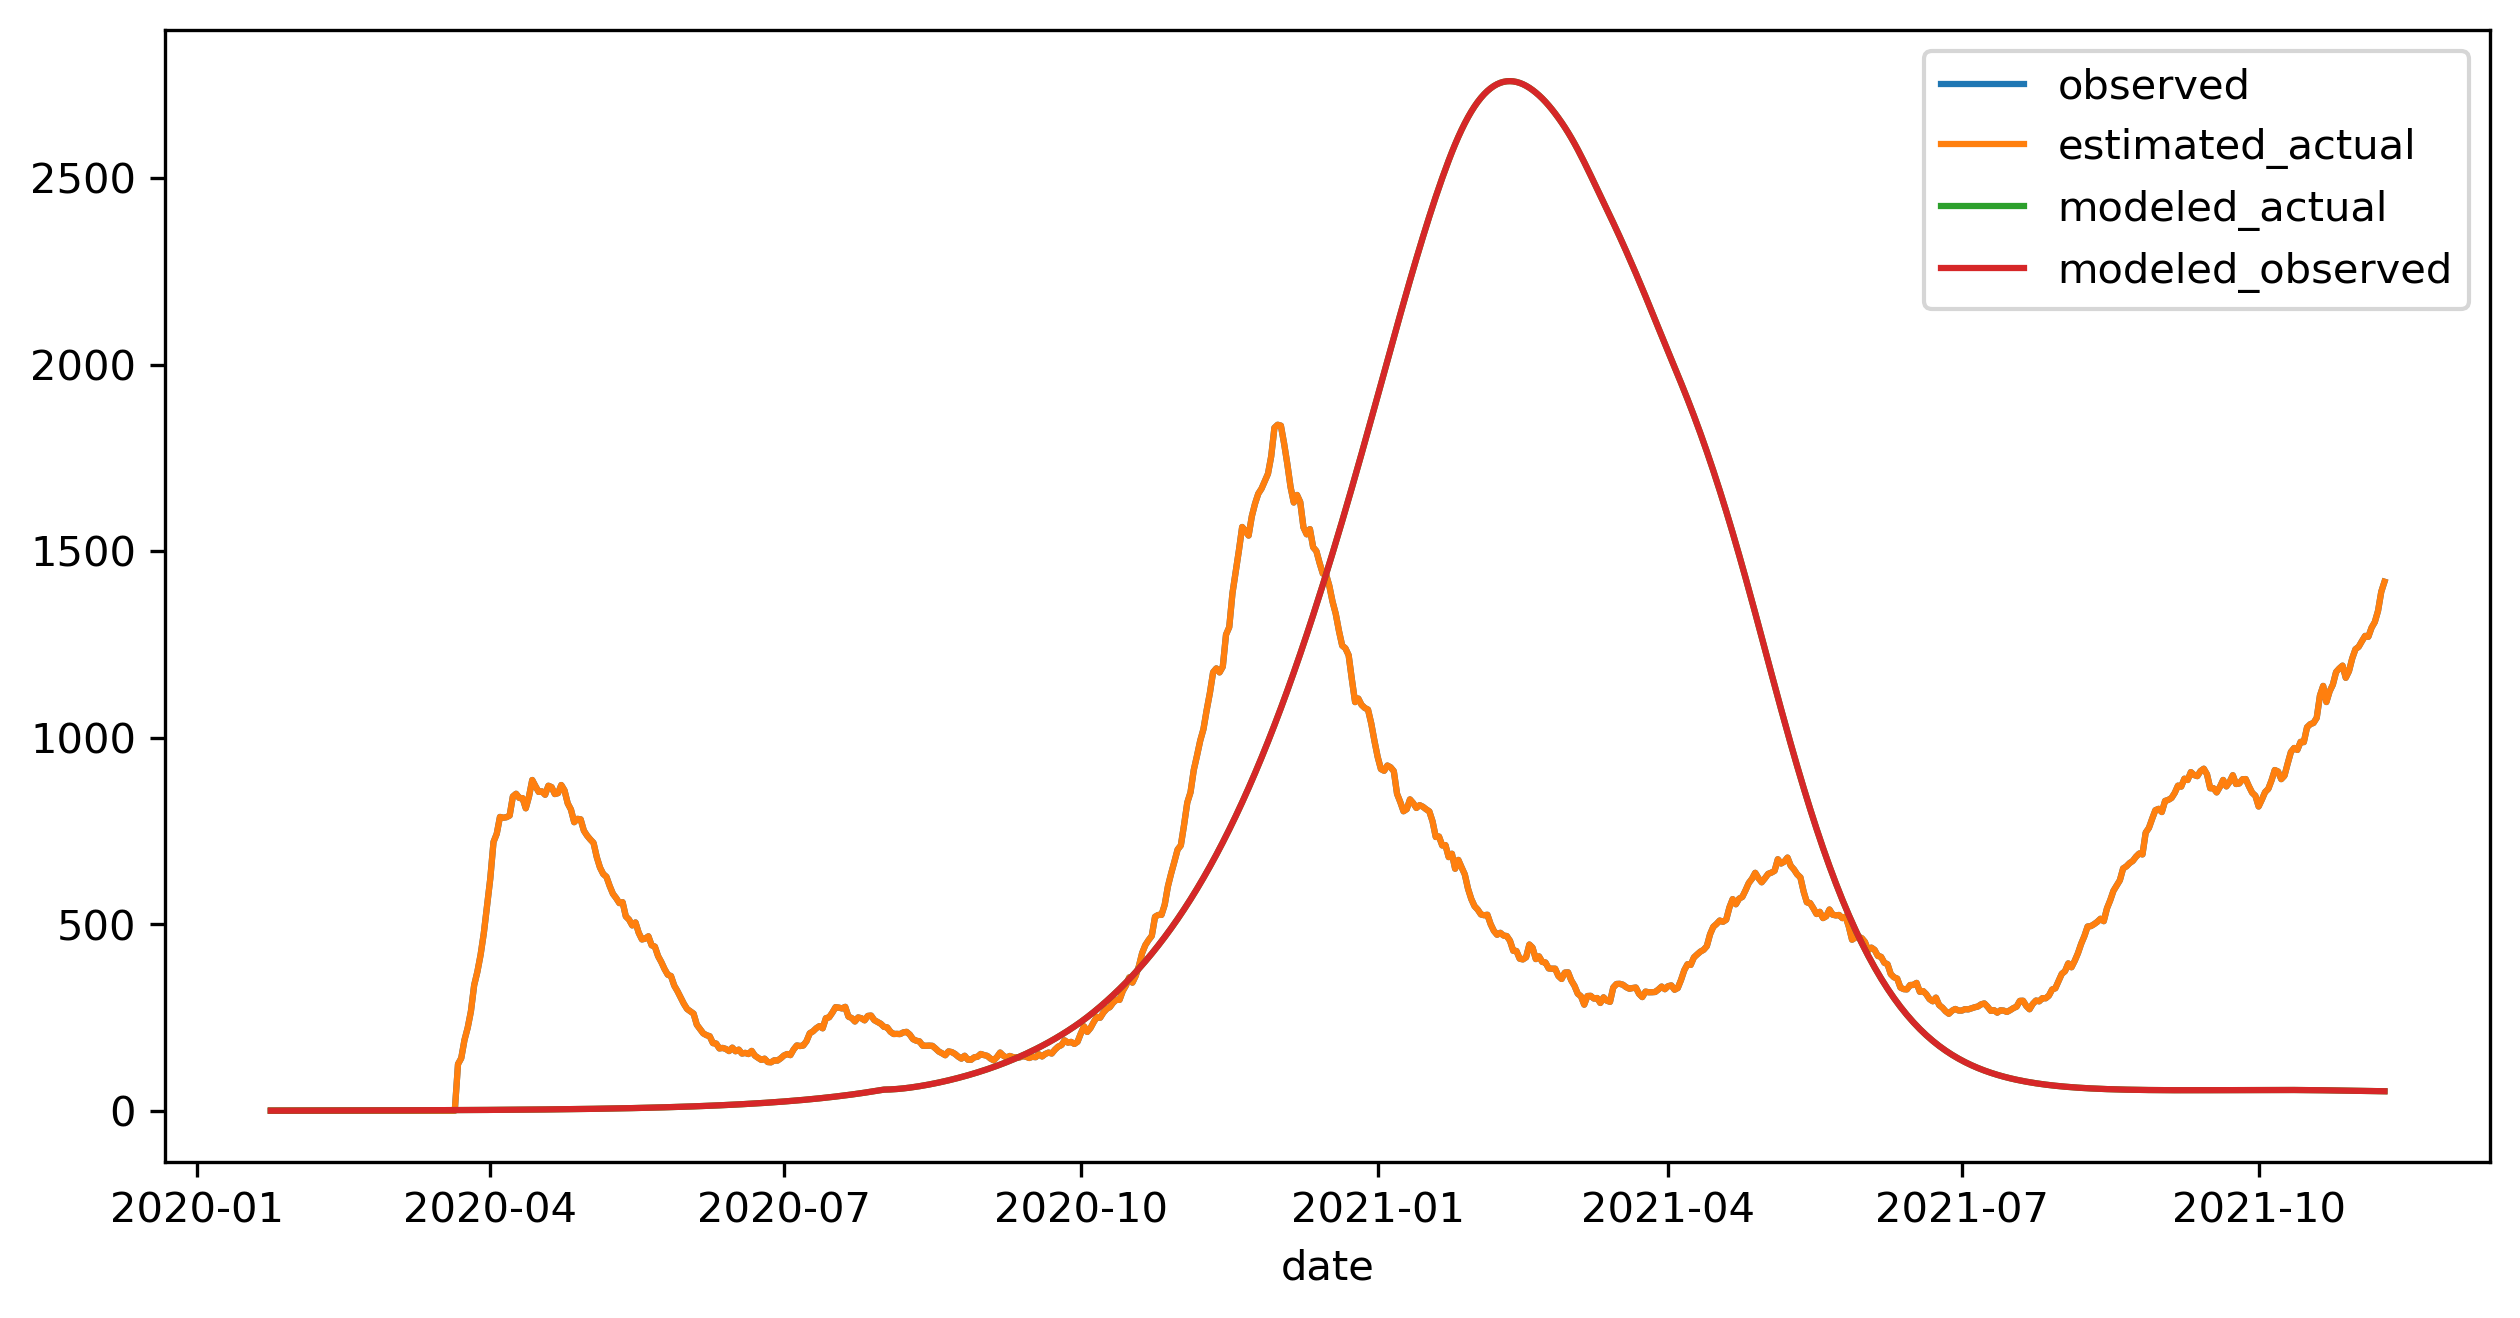

In [49]:
from matplotlib import pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(10, 5), dpi=300)
ax = fig.gca()
hosps_df.reset_index('region').drop(columns='region').plot(ax=ax)

First, since `hosp_reporting_frac` is always 1 for this model, the __observed__ and __estimated_actual__ columns will be the same, and the __modeled_actual__ and __modeled_observed__ columns will be the same. So some lines are being hidden behind other lines here.

Second, the answer to the question of how well the model agrees with reality is __not well__. This is why the model requires _fitting_, which we will discuss next.

# Fitting the Model

Fitting the model amounts to determining the _transmission control_ (TC) values which cause the modeled hospitalizations to agree with observed hospitalizations. TC can be specified at any day, but we have been fitting the model with TC being allowed to change every 14 days. Fitting is a process which involves the optimization of a function which inputs are TC values for different two-week periods, and output is a loss value capturing how much agreement there is between the observed and modeled hospitalizations over the time being modeled. The goal of fitting is to find the TC values which minimize the loss.

Practically, fitting takes place in several small batches, each batch covering a smaller amount of time and a few TC values. Batches may overlap, and batch characteristics are customizable, but an example of how batch fitting may look would involve the following steps:
1. Weeks 1-10 are fit, with TC changing every two weeks, meaning 5 TC values need to be fit. Hospitalizations from weeks 1-12 are used to compute the loss.
2. Weeks 5-14 are fit, meaning the two TC values for the first two weeks are "cemented" and considered part of the final fit.
3. Fitting continues in the sliding-window fashion until TC values for the entire fitting window have been fit.

Fitting can be done with the `do_single_fit` function in the `runnable_functions` module. Let's perform a fit on model `m3` (warning, this will take several minutes):

In [50]:
from covid_model.runnable_functions import do_single_fit
m3_fit = do_single_fit(outdir=outdir, tc_window_batch_size=5, tc_batch_increment=2, write_results=False, prep_model=False, base_model=m3)

2022/06/30 15:49:16 INFO|----------------------|{} Will fit 22 times
2022/06/30 15:50:29 INFO|----------------------|{'fit_batch': '0'}: Transmission control fit 1/22 completed in 73.40539554199995 seconds: {0: {'co': 0.8689258347996914}, 14: {'co': 0.6714930178918983}, 28: {'co': 0.5775358893640227}, 42: {'co': 0.06032058301268839}, 56: {'co': 0.5431700615399832}}
2022/06/30 15:50:29 INFO|-----------------------|{'fit_batch': '0'}: Running forward sim
2022/06/30 15:51:04 INFO|----------------------|{'fit_batch': '1'}: Transmission control fit 2/22 completed in 33.6902246249997 seconds: {28: {'co': 0.5544410931296845}, 42: {'co': 1.0549618172572369e-18}, 56: {'co': 0.7000632209389548}, 70: {'co': 0.8410213342933418}, 84: {'co': 0.7962538377889653}}
2022/06/30 15:51:04 INFO|-----------------------|{'fit_batch': '1'}: Running forward sim
2022/06/30 15:51:24 INFO|----------------------|{'fit_batch': '2'}: Transmission control fit 3/22 completed in 19.677735250000296 seconds: {56: {'co': 0

2022/06/30 15:59:24 INFO|-----------------------|{'fit_batch': '20'}: Running forward sim
2022/06/30 15:59:47 INFO|----------------------|{'fit_batch': '21'}: Transmission control fit 22/22 completed in 21.798738333000074 seconds: {574: {'co': 0.7537408375773098}, 588: {'co': 0.7946853131411741}, 602: {'co': 0.7664085855515789}, 616: {'co': 0.7285774646964471}, 630: {'co': 0.7333906745346664}}
2022/06/30 15:59:47 INFO|-----------------------|{'fit_batch': '21'}: Running forward sim
2022/06/30 15:59:48 INFO|----------------------|{'fit_batch': '21', 'run_type': 'fit'}: fitted TC: {0: {'co': 0.8689258391627107}, 14: {'co': 0.6714930181484233}, 28: {'co': 0.5544410931296845}, 42: {'co': 1.0549618172572369e-18}, 56: {'co': 0.6991798472311651}, 70: {'co': 0.8343746261820777}, 84: {'co': 0.8291018204159953}, 98: {'co': 0.8320030139020012}, 112: {'co': 0.8781687355706409}, 126: {'co': 0.821675346653838}, 140: {'co': 0.7611650674130149}, 154: {'co': 0.6689357652800505}, 168: {'co': 0.845221258

Now that the model has been fit, we can compare the modeled to observed hospitalizations again:

<AxesSubplot:xlabel='date'>

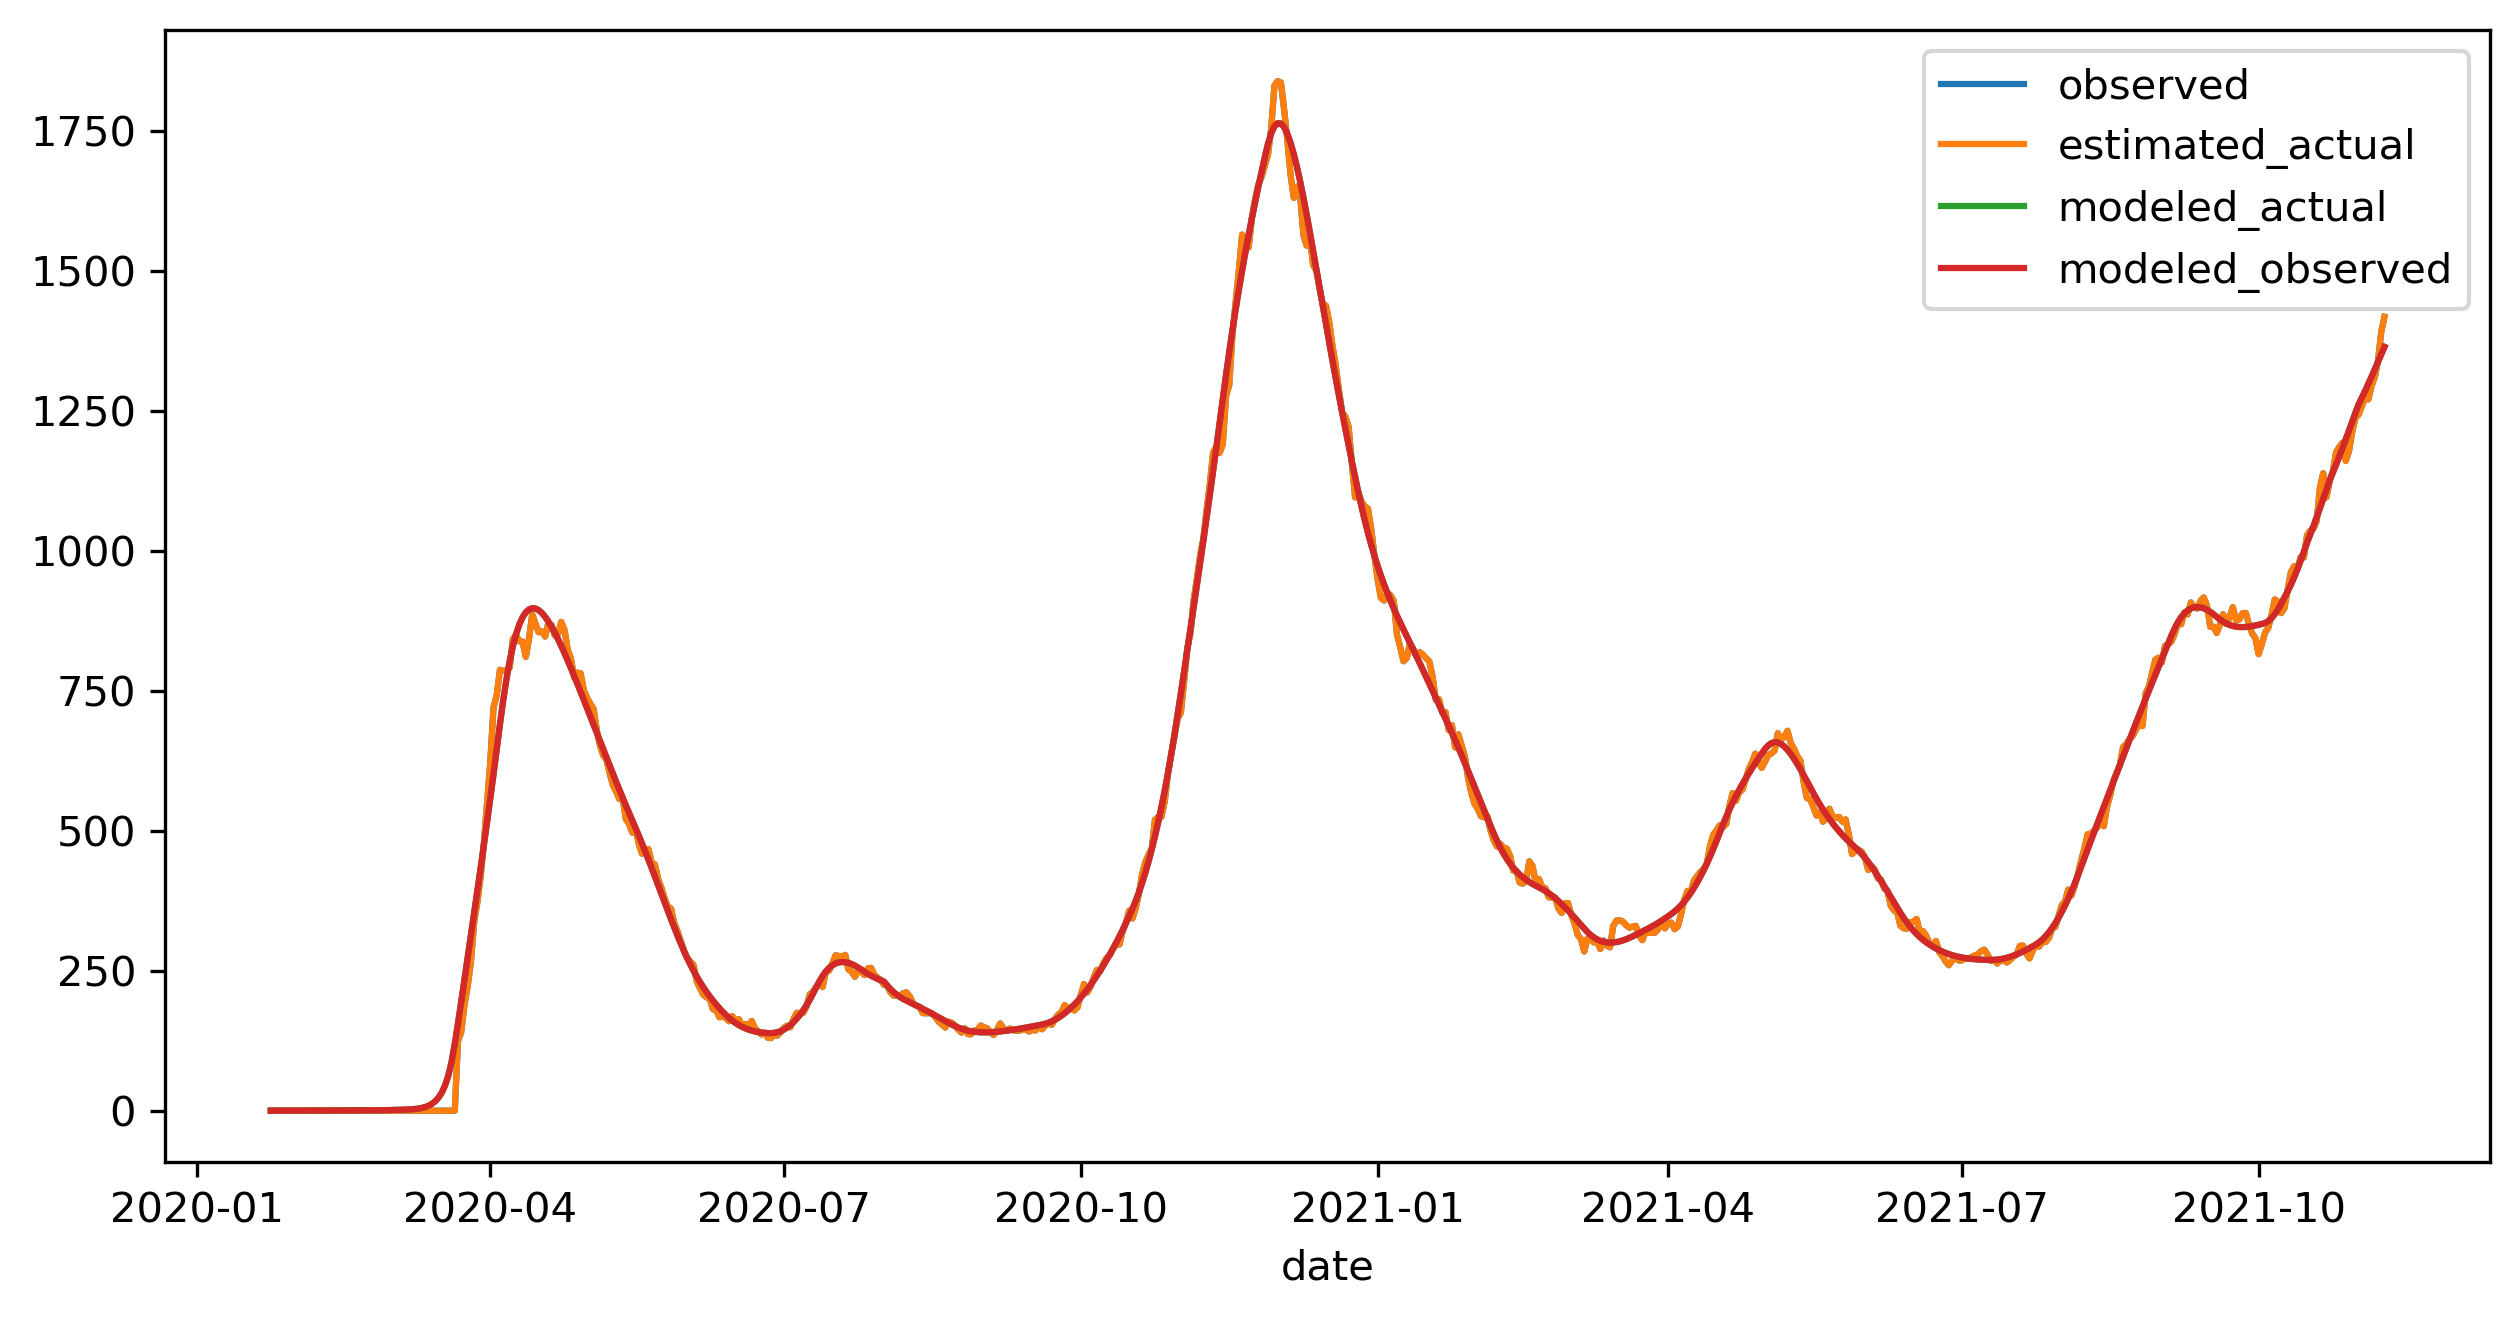

In [51]:
hosps_df = m3_fit.modeled_vs_observed_hosps()
fig = plt.figure(figsize=(10, 5), dpi=300)
ax = fig.gca()
hosps_df.reset_index('region').drop(columns='region').plot(ax=ax)

As you can see, the modeled and fit hospitalizations are in much better agreement! Also, if you check the output directory you should see images and .csv files created for each batch fit.



# Running Model Reports

Having fit a model, it's often useful to generate some standard reports to understand the model output. The `do_create_report` method from the `covid_models.runnable_functions` module.

In [52]:
from covid_model.runnable_functions import do_create_report
do_create_report(m3, outdir, immun_variants=['ba2121', 'ba2'], from_date='2021-01-01')
logging.info("report complete!")

2022/06/30 16:56:05 WARNING|No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
2022/06/30 16:57:03 INFO|report complete!


Check the output directory to see the graphics that were produced there! By the way, the `runnable_functions` module contains other useful scripts for fitting several models either one at a time or in parallel, fitting several different scenerios, etc.

This concludes this brief but hopefully informative look at getting started with running our model. This is actually one of the few (if not the only) Jupyter notebook in this repo. For a more traditional look at what an analysis script might look like, take a look at `00000000_hello_world.py` in this directory as well, which will also introduce some other useful function in the `runnable_functions` module.

Best of luck in your modeling endeavors!